<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, color_codes=True)
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-01 07:38:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-05-01 07:38:24 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

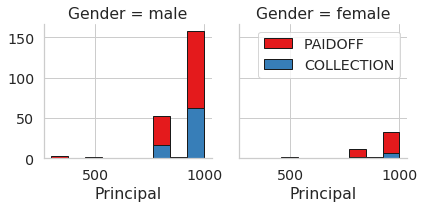

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

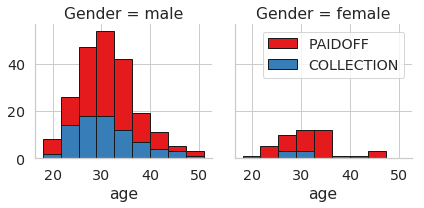

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

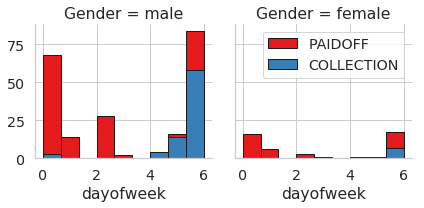

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [14]:
df['due_time'] = (df['due_date']-df['effective_date'])
df['due_time'] = (df['due_time']/np.timedelta64(1,'D')).astype('int')

## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend','due_time']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,due_time,Bechalor,High School or Below,college
0,1000,30,45,0,0,29,0,1,0
1,1000,30,33,1,0,29,1,0,0
2,1000,15,27,0,0,14,0,0,1
3,1000,30,28,1,1,29,0,0,1
4,1000,30,29,0,1,29,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,due_time,Bechalor,High School or Below,college
0,1000,30,45,0,0,29,0,1,0
1,1000,30,33,1,0,29,1,0,0
2,1000,15,27,0,0,14,0,0,1
3,1000,30,28,1,1,29,0,0,1
4,1000,30,29,0,1,29,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
         0.53257725, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         0.53257725,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.88417105, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.53257725, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.53257725, -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


# K Nearest Neighbor(KNN)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1, Ks):    
    #Train Model and Predict  
    model = KNeighborsClassifier(n_neighbors = n, n_jobs=-1, weights='uniform').fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)    
    std_acc[n-1] = np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

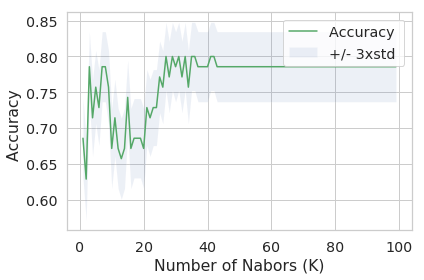

In [25]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [26]:
print( "The best accuracy is", mean_acc.max(), "when k=", mean_acc.argmax()+1) 

The best accuracy is 0.8 when k= 27


In [27]:
final_KNN = KNeighborsClassifier(n_neighbors = 50).fit(X_train,y_train)

# Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1, Ks):    
    #Train Model and Predict  
    decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    y_decision_pred = decision_tree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_decision_pred)    
    std_acc[n-1] = np.std(y_decision_pred == y_test)/np.sqrt(y_decision_pred.shape[0])
mean_acc

array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.78571429,
       0.78571429, 0.65714286, 0.71428571, 0.72857143, 0.67142857,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.68571429,
       0.68571429, 0.68571429, 0.67142857, 0.7       , 0.67142857,
       0.7       , 0.68571429, 0.68571429, 0.68571429, 0.7       ,
       0.68571429, 0.7       , 0.68571429, 0.7       , 0.7       ,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.68571429,
       0.68571429, 0.7       , 0.7       , 0.68571429, 0.68571429,
       0.67142857, 0.68571429, 0.68571429, 0.7       , 0.7       ,
       0.7       , 0.68571429, 0.68571429, 0.7       , 0.68571429,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.67142857,
       0.68571429, 0.67142857, 0.68571429, 0.68571429, 0.67142857,
       0.68571429, 0.7       , 0.7       , 0.68571429, 0.7       ,
       0.67142857, 0.68571429, 0.7       , 0.7       , 0.68571429,
       0.68571429, 0.7       , 0.7       , 0.68571429, 0.68571

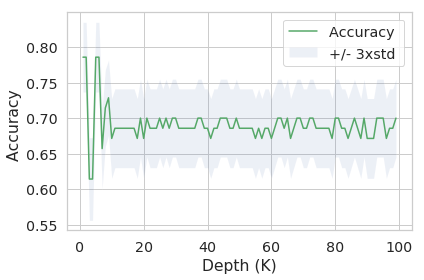

In [30]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth (K)')
plt.tight_layout()
plt.show()

In [31]:
print("Max depth after 15 intuitively seems more stable, but not so lower accuracy")

Max depth after 15 intuitively seems more stable, but not so lower accuracy


In [32]:
final_decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 21).fit(X_train,y_train)

# Support Vector Machine

In [33]:
from sklearn import svm

In [34]:
final_SVM = svm.SVC(kernel='linear')
final_SVM.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [35]:
metrics.accuracy_score(final_SVM.predict(X_test), y_test)

0.7714285714285715

# Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
# lRegression = LogisticRegression(C=0.03, solver='liblinear', max_iter=300).fit(X_train,y_train)

In [38]:
# metrics.accuracy_score(lRegression.predict(X_test), y_test)

In [39]:
Ks = 1000
lr_mean_acc = np.zeros((Ks-1))
lr_std_acc = np.zeros((Ks-1))
ConfustionMx = [];
i = 1
for n in np.arange(0.001,1,0.001 ): 
    model = LogisticRegression(C = n, solver = 'liblinear', max_iter=200).fit(X_train,y_train)
    y_pred = model.predict(X_test)
    lr_mean_acc[i-1] = metrics.accuracy_score(y_test, y_pred)    
    lr_std_acc[i-1] = np.std(y_pred == y_test)/np.sqrt(y_pred.shape[0])
    i = i +1

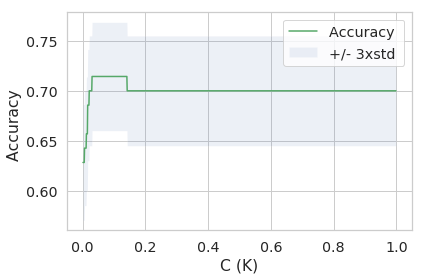

In [40]:
plt.plot(np.arange(0.001,1,0.001),lr_mean_acc,'g')
plt.fill_between(np.arange(0.001,1,0.001),lr_mean_acc - 1 * lr_std_acc,lr_mean_acc + 1 * lr_std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('C (K)')
plt.tight_layout()
plt.show()

In [41]:
print( "The best accuracy is seemingly", lr_mean_acc.max(), "when C is between 0.06 to 0.19(approx.)") 
mean_acc

The best accuracy is seemingly 0.7142857142857143 when C is between 0.06 to 0.19(approx.)


array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.78571429,
       0.78571429, 0.65714286, 0.71428571, 0.72857143, 0.67142857,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.68571429,
       0.68571429, 0.68571429, 0.67142857, 0.7       , 0.67142857,
       0.7       , 0.68571429, 0.68571429, 0.68571429, 0.7       ,
       0.68571429, 0.7       , 0.68571429, 0.7       , 0.7       ,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.68571429,
       0.68571429, 0.7       , 0.7       , 0.68571429, 0.68571429,
       0.67142857, 0.68571429, 0.68571429, 0.7       , 0.7       ,
       0.7       , 0.68571429, 0.68571429, 0.7       , 0.68571429,
       0.68571429, 0.68571429, 0.68571429, 0.68571429, 0.67142857,
       0.68571429, 0.67142857, 0.68571429, 0.68571429, 0.67142857,
       0.68571429, 0.7       , 0.7       , 0.68571429, 0.7       ,
       0.67142857, 0.68571429, 0.7       , 0.7       , 0.68571429,
       0.68571429, 0.7       , 0.7       , 0.68571429, 0.68571

In [42]:
final_lRegression = LogisticRegression(C=0.19, solver='liblinear', max_iter=200).fit(X_train,y_train)

# Model Evaluation using Test set

In [43]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [44]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-01 07:38:49--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-05-01 07:38:49 (321 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [45]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [46]:
y_true = df['loan_status'].values
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['due_time'] = (test_df['due_date']-test_df['effective_date'])
test_df['due_time'] = (test_df['due_time']/np.timedelta64(1,'D')).astype('int')
Feature = df[['Principal','terms','age','Gender','weekend','due_time']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X_true = Feature
X_true = preprocessing.StandardScaler().fit(X_true).transform(X_true)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


## 1. KNN

In [47]:
y_pred = final_KNN.predict(X_true)

### Jaccard

In [48]:
jaccard_knn = jaccard_similarity_score(y_pred, y_true)
jaccard_knn

0.7543352601156069

### F1- Score

In [49]:
f1score_knn = f1_score(y_pred, y_true, average='weighted')
f1score_knn

0.8570864570103521

## 2. Decision Tree

In [50]:
y_pred = final_decision_tree.predict(X_true)

### Jaccard Index

In [51]:
jaccard_decision_tree = jaccard_similarity_score(y_pred, y_true)
jaccard_decision_tree

0.8815028901734104

### F1 Score

In [52]:
f1score_decision_tree = f1_score(y_pred, y_true, average='weighted')
f1score_decision_tree

0.8792219222633426

## 3. SVM

In [53]:
y_pred = final_SVM.predict(X_true)

### Jaccard Index

In [54]:
jaccard_svm = jaccard_similarity_score(y_pred, y_true)
jaccard_svm

0.7572254335260116

### F1 Score

In [55]:
f1score_svm = f1_score(y_pred, y_true, average='weighted')
f1score_svm

0.8378447841098653

## 4. Logistic Regression

In [56]:
y_pred = final_lRegression.predict(X_true)

### Jaccard

In [57]:
jaccard_logistic_regression = jaccard_similarity_score(y_pred, y_true)
jaccard_logistic_regression

0.7514450867052023

### F1 Score

In [58]:
f1score_logistic_regression = f1_score(y_pred, y_true, average='weighted')
f1score_logistic_regression

0.7744370338984846

### Log Loss

In [59]:
np.place(y_pred, y_pred=='PAIDOFF', 1)
np.place(y_pred, y_pred=='COLLECTION', 0)
np.place(y_true, y_true=='PAIDOFF', 1)
np.place(y_true, y_true=='COLLECTION', 0)

In [60]:
y_pred = y_pred.astype(np.float)
y_true = y_true.astype(np.float)

In [61]:
logloss_logistic_regression = log_loss(y_pred, y_true)
logloss_logistic_regression

8.584842657501458

# Report
The accuracy of the built model using different evaluation metrics:

In [62]:
Jaccard = [jaccard_knn, jaccard_decision_tree, jaccard_svm, jaccard_logistic_regression]
F1_score = [f1score_knn, f1score_decision_tree, f1score_svm, f1score_logistic_regression]
LogLoss = ['NA','NA','NA',logloss_logistic_regression]

    
df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': Jaccard, 'F1-score': F1_score, 'LogLoss': LogLoss}

Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.754335,0.857086,NA
1,Decistion Tree,0.881503,0.879222,NA
2,SVM,0.757225,0.837845,NA
3,LogisticRegression,0.751445,0.774437,8.58484


# Report
The accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.803   | 0.812    | NA      |
| Decision Tree      | 0.864   | 0.861    | NA      |
| SVM                | 0.751   | 0.858    | NA      |
| LogisticRegression | 0.760   | 0.791    | 8.285   |

#### From this we can say that, Decision Tree has the better accuracy of about 88% in classifying the Paid-off and collection labels for this dataset in both Jaccard Index and F1 Score.